In [3]:
%pylab inline


import numpy as np
import torch
import os
import sys
import pickle
#Importing the package
root_dir = os.getcwd()
sys.path.append(os.path.abspath(root_dir+'/WCRG'))
sys.path.append(os.path.abspath(root_dir+'/WCRG/WCRG'))
sys.path.append(os.path.abspath(root_dir+'/WCRG/Wavelet_Packets'))
sys.path.append(os.path.abspath(root_dir+'/WCRG/WCRG/Models'))
#Wavelets
from Wavelet_Packets import *
#Ansatz
from WCRG import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
root_dir

'/sps/lsst/users/campagne/DGanVsWcrg'

In [4]:
#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Learning WCRG model on WL maps (pixel values standardized, aka TRANS)

In [5]:
#data
data = np.load(root_dir+"/DGAN/cosmo_primary_128_5k_train_trans.npy")

In [6]:
#to pytorch
Data = torch.tensor(data).to(device).to(torch.float32)

In [8]:
print(Data.shape, Data.mean(),Data.std())

torch.Size([5000, 128, 128]) tensor(0.0061, device='cuda:0') tensor(0.9984, device='cuda:0')


In [9]:
#Computing the number of scales
J=int(np.log2(Data.shape[-1])) #Images of size 2**J
print('J = '+str(J))

J = 7


In [10]:
#Wavelet
m=4
W=Db_wavelets(m,device=device,mode='Periodic') #Debauchies 4

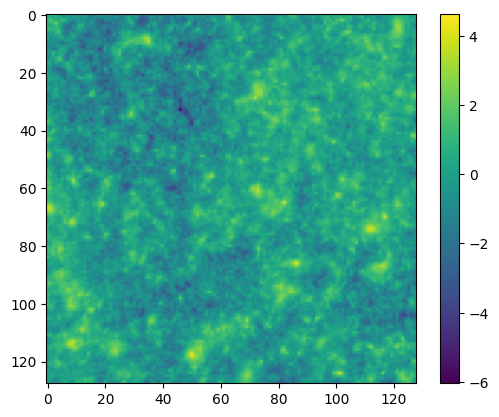

tensor(-0.1342, device='cuda:0')


In [11]:
imshow(Data[0].cpu());colorbar();
show()
print(Data[0].mean())

In [12]:
def my_optim(ansatz_union,dataloader,num_epochs,lr,momentum=0,weight_decay=0):
    """Ansatz optimisation with SGD
    
    Parameters:
    ansatz_union (Condi_union) : ansatz to optimise
    dataloader (torch Dataloader):  with x_{j-1} maps for conditional models
    num_epochs (int) :number of steps
    lr (float) : learning rate
    momentum : momentum in SGD
    weight_decay : l2 renormalisation in SGD
    
    """

    optimizer = torch.optim.SGD([ansatz_union.theta_no_rescale], lr=lr, momentum=momentum, weight_decay=weight_decay)
    for _ in range(num_epochs):
        for x in dataloader:
            l=Loss_score(x,ansatz_union)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        print( '[{}/{}] loss: {:.8}'.format(_, num_epochs, l.cpu().detach().numpy() ) )

# We train the ansatz $E(x_J)$

In [13]:
#Loading Data x_J
L=1
depth = J-int(np.log2(L))
phi_s = load_data(W,Data,depth,J,show_hist=False)

In [14]:
phi_s.shape

torch.Size([5000, 1, 1])

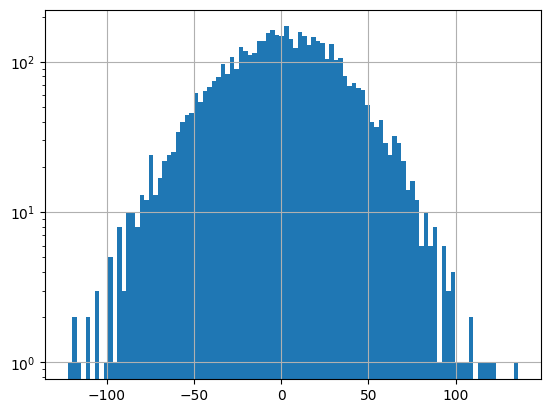

In [15]:
plt.hist(phi_s.cpu().reshape((-1)),bins=100);
plt.yscale('log')
plt.grid()
plt.show()

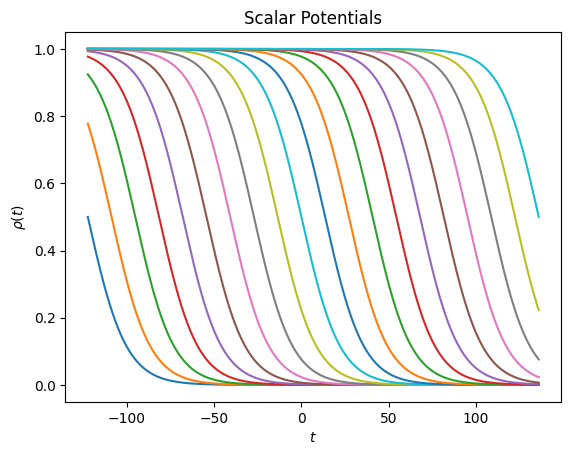

In [16]:
#Scalar Potentials Positioning
num_potentials = 20
# For linspaced potentials
window_min,window_max = phi_s.min(),phi_s.max() #The window to consider for scalar potentials
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =0.8,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials, quantile_min=0.001,quantile_max=0.999,
#                                 extent=1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = ()
#Ansatz
ansatz = ANSATZ_NoCondi(L,centers,sigma,shifts,shifts_sym = False)

In [17]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s, batch_size=1000)
#Normalise Hessian in order to improve conditionning
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
#Optimisation
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

/sps/lsst/users/campagne/anaconda3/envs/pytexture/lib/python3.8/site-packages/torch/_functorch/deprecated.py:80: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.jacrev is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.func.jacrev instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.html
  warn_deprecated('jacrev')
/sps/lsst/users/campagne/anaconda3/envs/pytexture/lib/python3.8/site-packages/torch/_functorch/deprecated.py:58: UserWarning: We've integrated functorch into PyTorch. As the final step of the integration, functorch.vmap is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use torch.vmap instead; see the PyTorch 2.0 release notes and/or the torch.func migration guide for more details https://pytorch.org/docs/master/func.migrating.ht

[0/30] loss: -0.00047937717
[1/30] loss: -0.00066538772
[2/30] loss: -0.00074049359
[3/30] loss: -0.00086415163
[4/30] loss: -0.00077698572
[5/30] loss: -0.00075805048
[6/30] loss: -0.00082998403
[7/30] loss: -0.00091083866
[8/30] loss: -0.00084129814
[9/30] loss: -0.00092696678
[10/30] loss: -0.00091109209
[11/30] loss: -0.00077453651
[12/30] loss: -0.0006601605
[13/30] loss: -0.00081125612
[14/30] loss: -0.00073907984
[15/30] loss: -0.00072828919
[16/30] loss: -0.00082116912
[17/30] loss: -0.00081281428
[18/30] loss: -0.0007116865
[19/30] loss: -0.00090747961
[20/30] loss: -0.00080975605
[21/30] loss: -0.00073093642
[22/30] loss: -0.00076153467
[23/30] loss: -0.00087288063
[24/30] loss: -0.00077304372
[25/30] loss: -0.00088890642
[26/30] loss: -0.00083793962
[27/30] loss: -0.00072035327
[28/30] loss: -0.00074576447
[29/30] loss: -0.00074302527
[0/10] loss: -0.00080874766
[1/10] loss: -0.00089214201
[2/10] loss: -0.0008914739
[3/10] loss: -0.00076321739
[4/10] loss: -0.00086962548
[5/

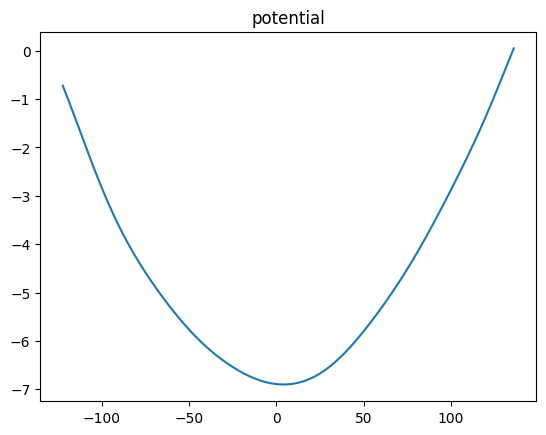

In [18]:
#Visualize Potential
Show_Sigmoid(ansatz,add_Trace=True,Free=False,index_scalar=0,index_quad=1)

In [19]:
KEY="map_128"
dir_synth = './SynthsTrans/'
dir_mod = './ModelsTrans/'

In [20]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 2

In [21]:
#Loading Data x_j
L=2
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 6


In [22]:
phi_s.shape

torch.Size([5000, 2, 2])

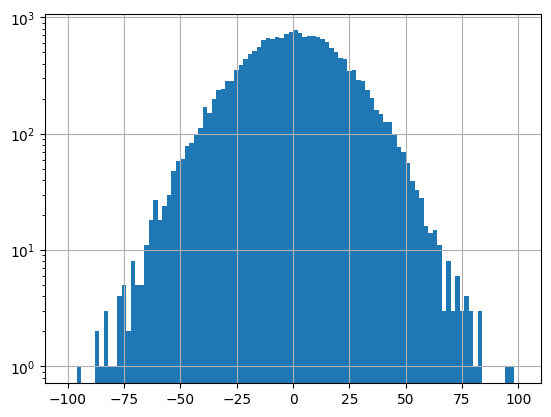

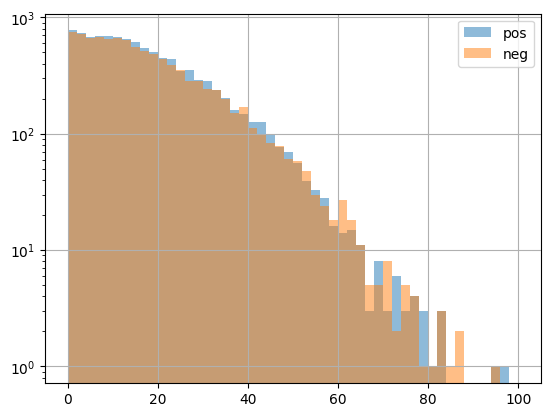

In [23]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-100,100));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,100),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,100),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

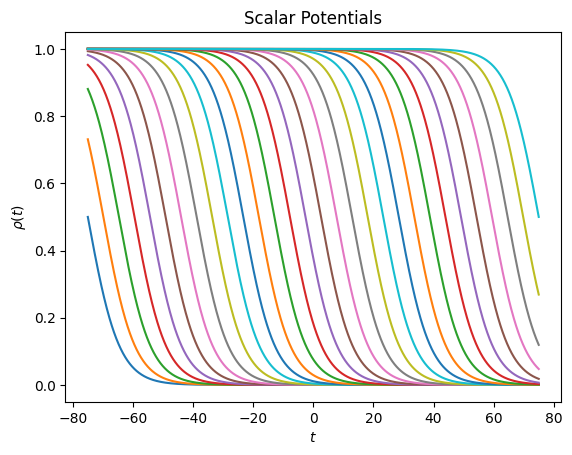

In [24]:
#Scalar Potentials Positioning
num_potentials = 30
window_min,window_max = (-75,75)# phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials, quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = ()
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [25]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s, batch_size=1000)
#Normalise Hessian in order to improve conditionning
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=20,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/20] loss: -0.0070823524
[1/20] loss: -0.010285396
[2/20] loss: -0.011371613
[3/20] loss: -0.012297298
[4/20] loss: -0.01288854
[5/20] loss: -0.013687122
[6/20] loss: -0.012031416
[7/20] loss: -0.011737683
[8/20] loss: -0.012910843
[9/20] loss: -0.012174809
[10/20] loss: -0.012839875
[11/20] loss: -0.013367219
[12/20] loss: -0.012991915
[13/20] loss: -0.011917699
[14/20] loss: -0.012355646
[15/20] loss: -0.012444166
[16/20] loss: -0.013108753
[17/20] loss: -0.013467998
[18/20] loss: -0.012597184
[19/20] loss: -0.012596535
[0/10] loss: -0.01252469
[1/10] loss: -0.013924252
[2/10] loss: -0.012606394
[3/10] loss: -0.013669097
[4/10] loss: -0.013463425
[5/10] loss: -0.01322657
[6/10] loss: -0.012949985
[7/10] loss: -0.013606081
[8/10] loss: -0.013328958
[9/10] loss: -0.012831189


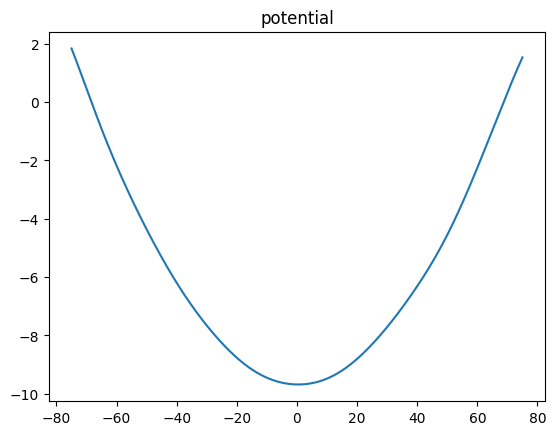

In [26]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [27]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 4

In [29]:
L=4
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 5


In [30]:
phi_s.shape

torch.Size([5000, 4, 4])

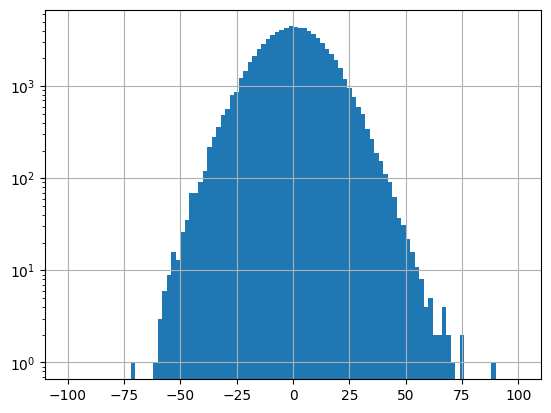

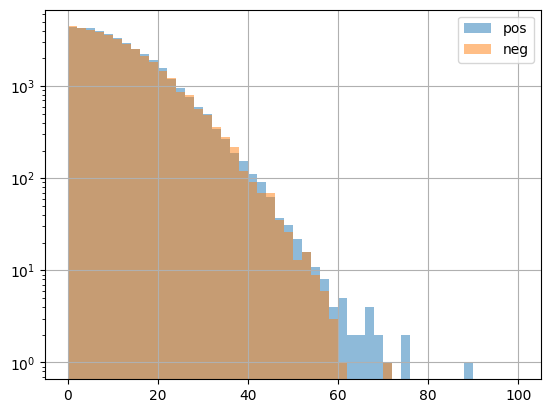

In [31]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-100,100));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,100),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,100),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

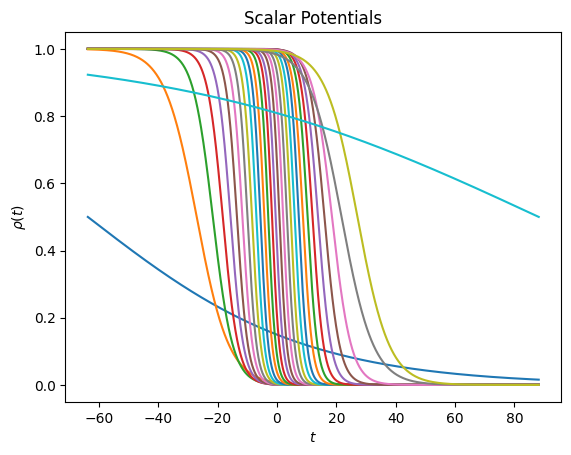

In [32]:
#Scalar Potentials Positioning
num_potentials = 30
#window_min,window_max = (-65,65)# phi_s.min(),phi_s.max()#phi_s.min(),phi_s.max()
#centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.00001,quantile_max=1.0,
                                 extent =1,device=device)
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = ((1,0),(0,1),(1,1))
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts,shifts_sym=True)

In [33]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=100)
#Normalise Hessian in order to improve conditionning
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-3,momentum=0,weight_decay=0)

[0/30] loss: -0.057184886
[1/30] loss: -0.084021546
[2/30] loss: -0.09451966
[3/30] loss: -0.097172059
[4/30] loss: -0.089248128
[5/30] loss: -0.1013629
[6/30] loss: -0.09679579
[7/30] loss: -0.11290833
[8/30] loss: -0.094024807
[9/30] loss: -0.095905833
[10/30] loss: -0.1183949
[11/30] loss: -0.095274515
[12/30] loss: -0.10925506
[13/30] loss: -0.11720084
[14/30] loss: -0.10744546
[15/30] loss: -0.1088798
[16/30] loss: -0.1050766
[17/30] loss: -0.12110031
[18/30] loss: -0.12049663
[19/30] loss: -0.1273773
[20/30] loss: -0.10235108
[21/30] loss: -0.093559608
[22/30] loss: -0.11217856
[23/30] loss: -0.11462093
[24/30] loss: -0.10770527
[25/30] loss: -0.11458725
[26/30] loss: -0.10089368
[27/30] loss: -0.11030879
[28/30] loss: -0.13076399
[29/30] loss: -0.112295
[0/30] loss: -0.11315916
[1/30] loss: -0.13712533
[2/30] loss: -0.10579617
[3/30] loss: -0.11244535
[4/30] loss: -0.097792089
[5/30] loss: -0.10178669
[6/30] loss: -0.12118958
[7/30] loss: -0.13659719
[8/30] loss: -0.10395578
[9/

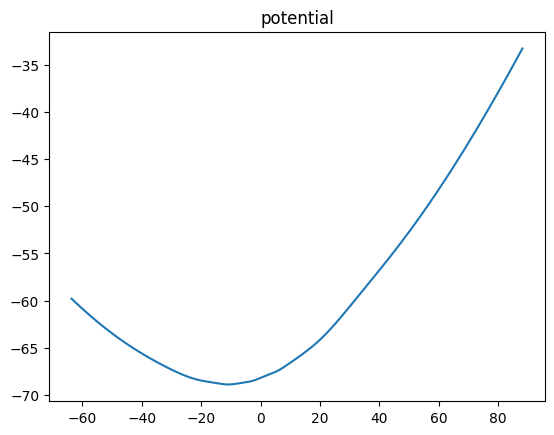

In [34]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [35]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L= 8

In [36]:
L=8
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 4


In [37]:
phi_s.shape

torch.Size([5000, 8, 8])

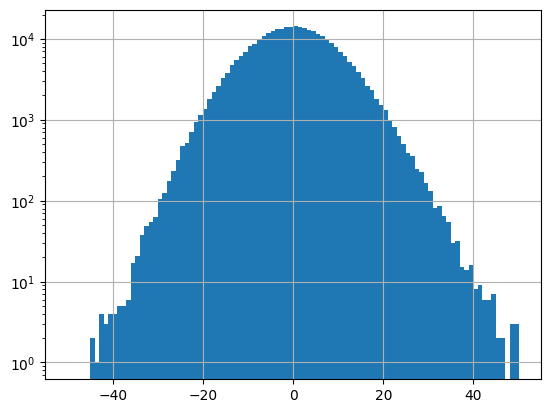

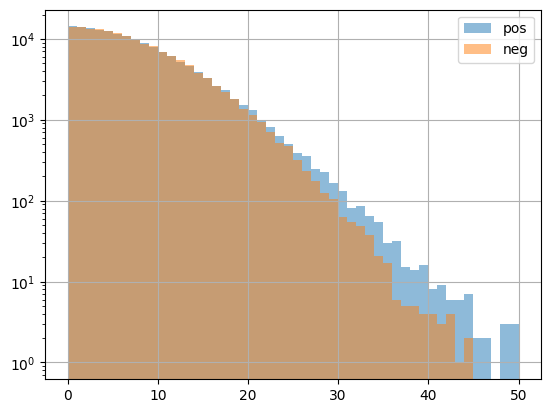

In [38]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-50,50));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,50),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,50),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

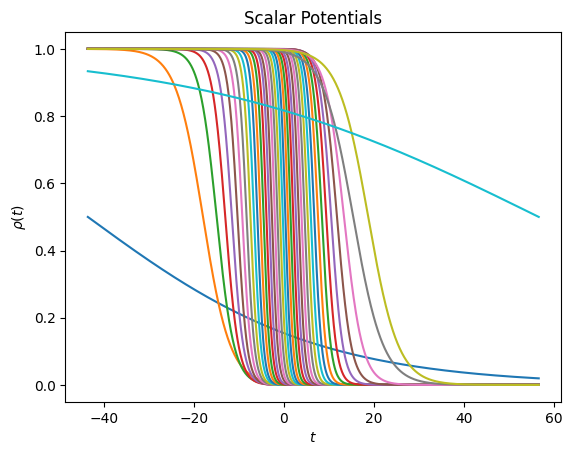

In [39]:
#Scalar Potentials Positioning
num_potentials = 40
#window_min,window_max = (-50,50)# phi_s.min(),phi_s.max()
#centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.00001,quantile_max=1.0,
                                 extent =1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(2,2)  # shifts_quad(2,2) #JEC 14/June+23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [40]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::5], batch_size=100)
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/30] loss: -0.99073708
[1/30] loss: -1.1196302
[2/30] loss: -1.1936927
[3/30] loss: -1.2794896
[4/30] loss: -1.2821146
[5/30] loss: -1.2668791
[6/30] loss: -1.3221824
[7/30] loss: -1.333195
[8/30] loss: -1.2775106
[9/30] loss: -1.2348356
[10/30] loss: -1.3075949
[11/30] loss: -1.3306893
[12/30] loss: -1.2830876
[13/30] loss: -1.3037106
[14/30] loss: -1.3547001
[15/30] loss: -1.2936083
[16/30] loss: -1.3435457
[17/30] loss: -1.2441883
[18/30] loss: -1.2666466
[19/30] loss: -1.2628963
[20/30] loss: -1.2935202
[21/30] loss: -1.3280485
[22/30] loss: -1.2370402
[23/30] loss: -1.2568657
[24/30] loss: -1.3963071
[25/30] loss: -1.3773066
[26/30] loss: -1.3410677
[27/30] loss: -1.3101612
[28/30] loss: -1.3055403
[29/30] loss: -1.3982773
[0/10] loss: -1.2951736
[1/10] loss: -1.4099562
[2/10] loss: -1.3683668
[3/10] loss: -1.3444326
[4/10] loss: -1.2555388
[5/10] loss: -1.331638
[6/10] loss: -1.2925291
[7/10] loss: -1.3277969
[8/10] loss: -1.3146152
[9/10] loss: -1.3603462


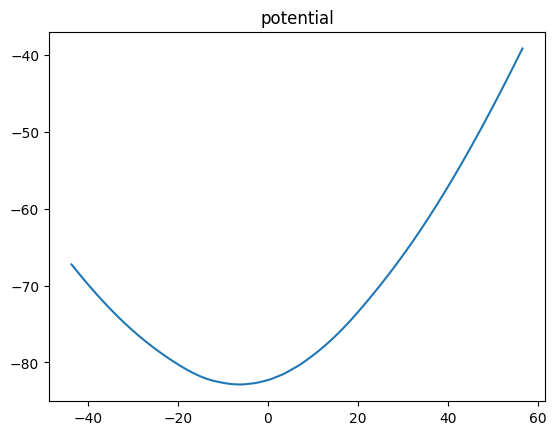

In [41]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [42]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 16

In [43]:
L=16
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 3


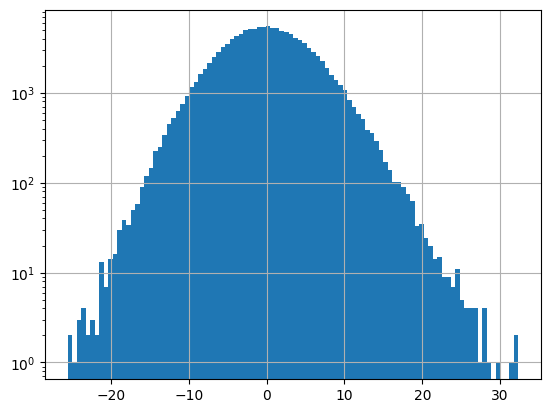

In [44]:
plt.hist(phi_s[::10].cpu().reshape((-1)),bins=100);
plt.yscale('log')
plt.grid()
plt.show()

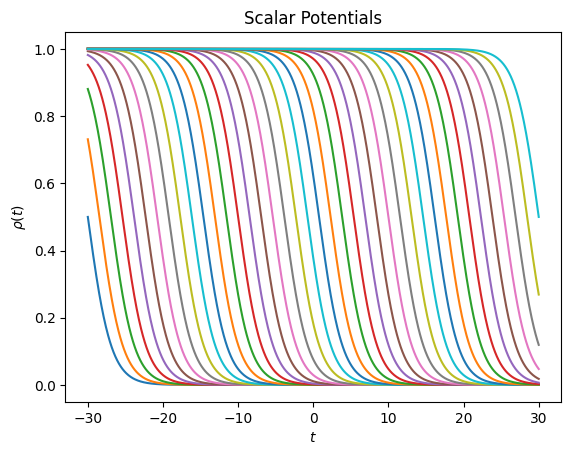

In [45]:
#Scalar Potentials Positioning
num_potentials = 40
window_min,window_max = (-30,30) #phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(4,4)  #shifts_quad(4,4)  # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [46]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=100)
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=50,lr=5e-3,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/50] loss: -4.9346404
[1/50] loss: -8.8464375
[2/50] loss: -11.358989
[3/50] loss: -13.176996
[4/50] loss: -13.945009
[5/50] loss: -14.59054
[6/50] loss: -15.014081
[7/50] loss: -15.328254
[8/50] loss: -15.676555
[9/50] loss: -15.76638
[10/50] loss: -16.028065
[11/50] loss: -16.294621
[12/50] loss: -16.391907
[13/50] loss: -16.668112
[14/50] loss: -16.571558
[15/50] loss: -17.551495
[16/50] loss: -17.09692
[17/50] loss: -16.656136
[18/50] loss: -16.927654
[19/50] loss: -16.89595
[20/50] loss: -17.425964
[21/50] loss: -16.867146
[22/50] loss: -17.224316
[23/50] loss: -17.235561
[24/50] loss: -17.560986
[25/50] loss: -17.185307
[26/50] loss: -17.552177
[27/50] loss: -17.279949
[28/50] loss: -17.12159
[29/50] loss: -17.47858
[30/50] loss: -16.944103
[31/50] loss: -17.450977
[32/50] loss: -17.763033
[33/50] loss: -17.706644
[34/50] loss: -17.35936
[35/50] loss: -17.84219
[36/50] loss: -17.592613
[37/50] loss: -17.085663
[38/50] loss: -17.299059
[39/50] loss: -17.393183
[40/50] loss: -17.

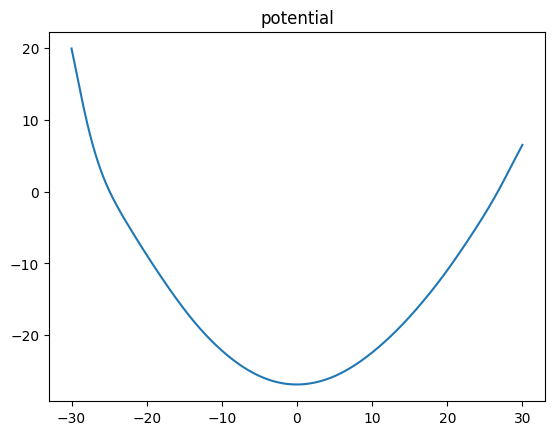

In [47]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [48]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 32

In [49]:
L=32
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 2


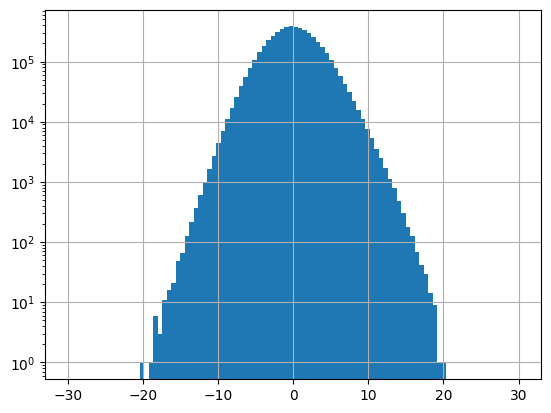

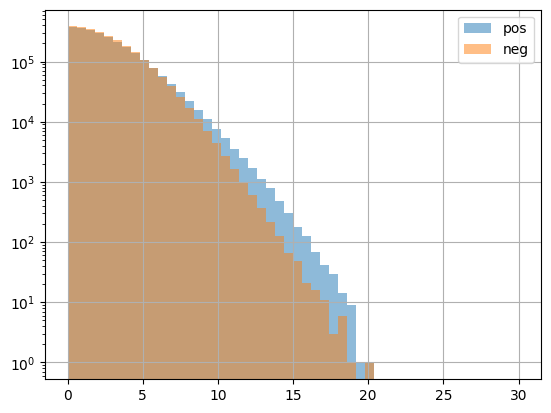

In [50]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-30,30));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,30),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,30),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

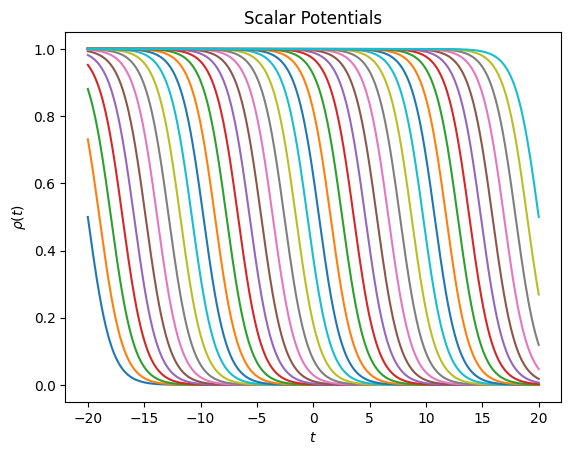

In [51]:
#Scalar Potentials Positioning
num_potentials = 40
window_min,window_max = (-20, 20) #phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(6,6)   #shifts_quad(8,8) # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [52]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=50) # JEC was phi_s[::50] 19/6/23
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
my_optim(ansatz,dataloader,num_epochs=50,lr=2e-3,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/50] loss: -62.038048
[1/50] loss: -107.6028
[2/50] loss: -140.91931
[3/50] loss: -162.22313
[4/50] loss: -179.41235
[5/50] loss: -192.82166
[6/50] loss: -200.07207
[7/50] loss: -210.78114
[8/50] loss: -216.02176
[9/50] loss: -219.09258
[10/50] loss: -222.52092
[11/50] loss: -228.69675
[12/50] loss: -233.82942
[13/50] loss: -236.6879
[14/50] loss: -235.6584
[15/50] loss: -240.81978
[16/50] loss: -242.66685
[17/50] loss: -242.19868
[18/50] loss: -242.63725
[19/50] loss: -245.07658
[20/50] loss: -248.68242
[21/50] loss: -253.29807
[22/50] loss: -249.37021
[23/50] loss: -249.10506
[24/50] loss: -250.20731
[25/50] loss: -254.74022
[26/50] loss: -249.73433
[27/50] loss: -250.72467
[28/50] loss: -252.31007
[29/50] loss: -255.40678
[30/50] loss: -256.09549
[31/50] loss: -253.38831
[32/50] loss: -254.1196
[33/50] loss: -256.07251
[34/50] loss: -252.30237
[35/50] loss: -257.0174
[36/50] loss: -258.81805
[37/50] loss: -252.44386
[38/50] loss: -255.56296
[39/50] loss: -256.14978
[40/50] loss: -

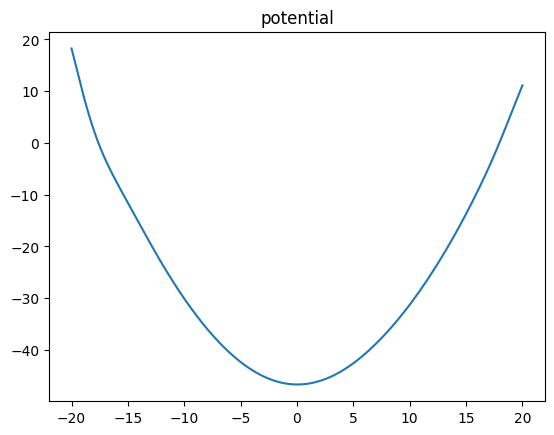

In [53]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [54]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 64

In [81]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [82]:
L=64
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 1


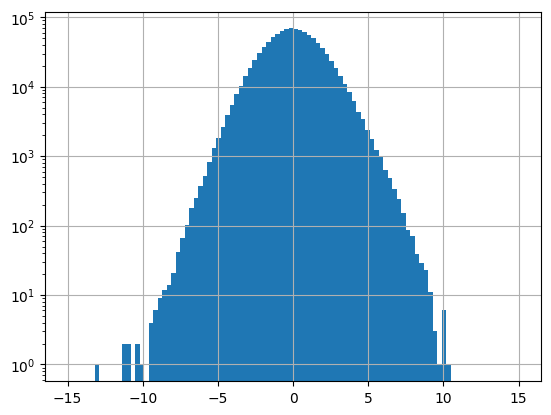

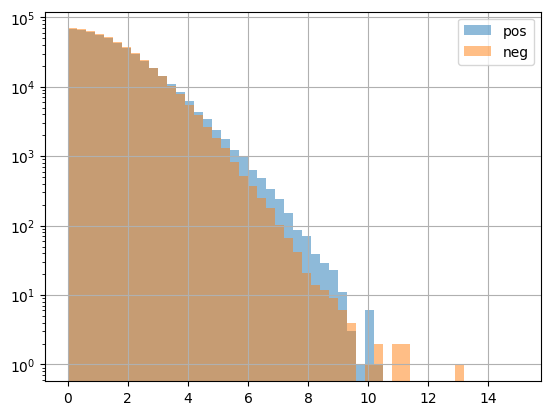

In [76]:
tmp = phi_s.cpu().reshape((-1))[::20]
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-15,15));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,15),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,15),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

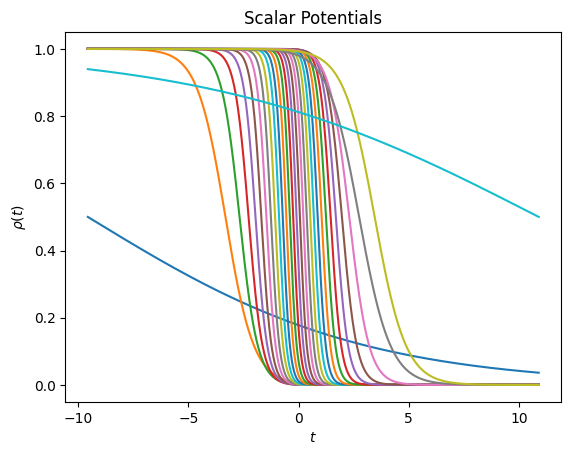

In [84]:
#Scalar Potentials Positioning
num_potentials = 30
#window_min,window_max = (-11,11) #phi_s.min(),phi_s.max()
#centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent=1.0,device=device)

centers,sigma = quantile_centers(phi_s[::10],num_potentials,quantile_min=0.00001,quantile_max=1.0,
                                 extent =1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(6,6)  # shifts_quad(4,4) # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [85]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::20], batch_size=50)  # JEC was phi_s[::20] 19/6/23
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
my_optim(ansatz,dataloader,num_epochs=40,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=20,lr=1e-3,momentum=0,weight_decay=0)

[0/40] loss: -2214.6147
[1/40] loss: -3303.4688
[2/40] loss: -3852.0938
[3/40] loss: -4179.3506
[4/40] loss: -4402.4136
[5/40] loss: -4567.8828
[6/40] loss: -4707.6147
[7/40] loss: -4832.4717
[8/40] loss: -4917.5103
[9/40] loss: -5009.1729
[10/40] loss: -4994.209
[11/40] loss: -5057.8999
[12/40] loss: -5154.3848
[13/40] loss: -5152.8257
[14/40] loss: -5170.5552
[15/40] loss: -5223.9604
[16/40] loss: -5265.6919
[17/40] loss: -5275.7446
[18/40] loss: -5272.7876
[19/40] loss: -5269.2539
[20/40] loss: -5317.1235
[21/40] loss: -5305.604
[22/40] loss: -5338.8662
[23/40] loss: -5303.0015
[24/40] loss: -5330.1021
[25/40] loss: -5357.6333
[26/40] loss: -5337.2603
[27/40] loss: -5320.1143
[28/40] loss: -5346.3887
[29/40] loss: -5360.1494
[30/40] loss: -5315.0044
[31/40] loss: -5387.6641
[32/40] loss: -5352.3013
[33/40] loss: -5341.7358
[34/40] loss: -5365.0562
[35/40] loss: -5356.5293
[36/40] loss: -5359.8545
[37/40] loss: -5369.061
[38/40] loss: -5380.9346
[39/40] loss: -5367.5513
[0/20] loss: 

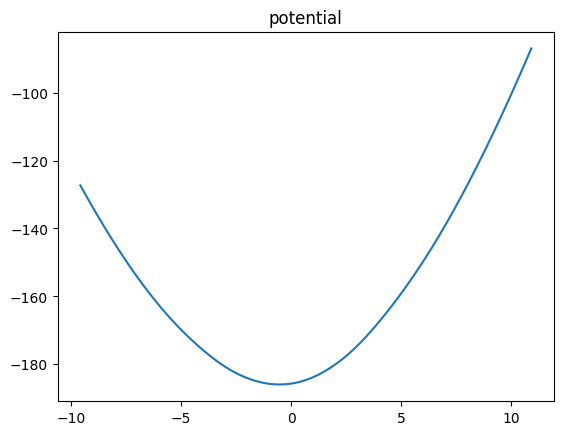

In [86]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [87]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 128

In [88]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [89]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 0


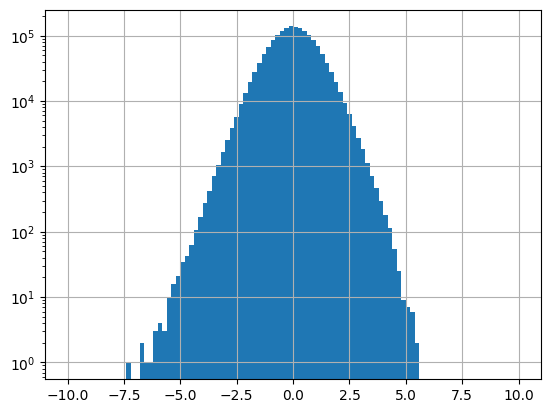

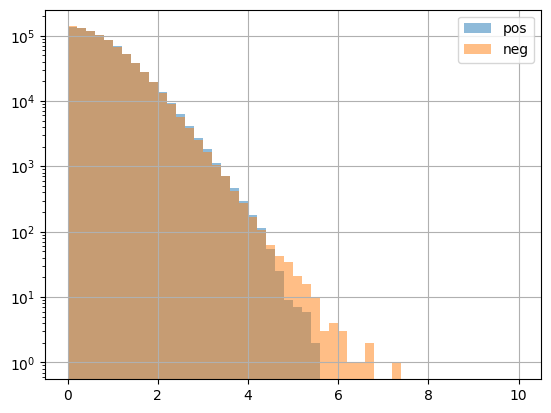

In [63]:
tmp = phi_s.cpu().reshape((-1))[::50]
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-10,10));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,10),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,10),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

In [67]:
phi_s.min(),phi_s.max()

(tensor(-89.3932, device='cuda:0'), tensor(6.1977, device='cuda:0'))

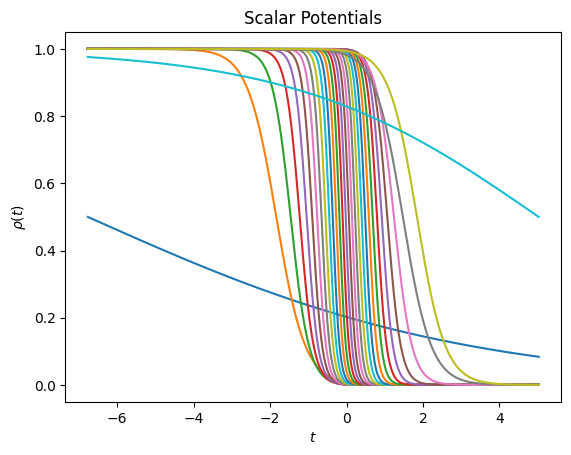

In [95]:
#Scalar Potentials Positioning
num_potentials = 30
#window_min,window_max = (-8,6) #phi_s.min(),phi_s.max()
#centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =0.5*0.5,device='cuda')
centers,sigma = quantile_centers(phi_s[::50],num_potentials, quantile_min=0.000005,quantile_max=0.999995,
                                 extent =1.0,device='cuda')

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(6,6)  # shifts_quad(6,6) # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [96]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=10)
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
my_optim(ansatz,dataloader,num_epochs=10,lr=5e-3,momentum=0,weight_decay=0) #epoch 2, lr=2e-2
my_optim(ansatz,dataloader,num_epochs=2,lr=1e-3,momentum=0,weight_decay=0)


[0/10] loss: -84138.945
[1/10] loss: -94011.695
[2/10] loss: -97214.602
[3/10] loss: -98511.625
[4/10] loss: -99671.883
[5/10] loss: -99608.484
[6/10] loss: -100019.66
[7/10] loss: -99755.18
[8/10] loss: -101695.68
[9/10] loss: -101483.97
[0/2] loss: -100307.36
[1/2] loss: -101632.0


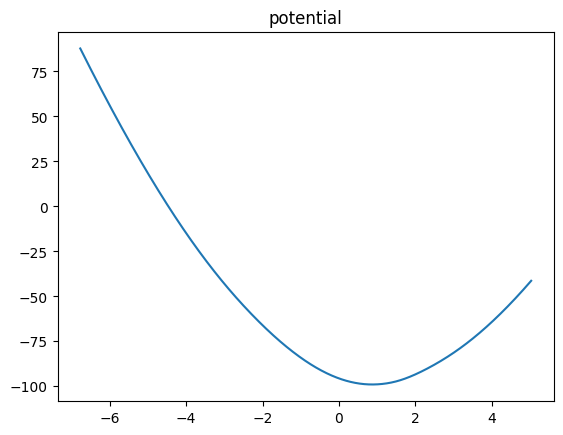

In [97]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [98]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

In [69]:
Nscale=8 # 8

STD = []
for j in range(1,Nscale):
  L=2**j
  depth = J-int(np.log2(L))
  print('depth = '+str(depth))
  phi_s = load_data(W,Data,depth,J,show_hist=False)
  STD.append(phi_s.std())

depth = 6
depth = 5
depth = 4
depth = 3
depth = 2
depth = 1
depth = 0


In [71]:
ANSATZ =[]
for j in range(1,Nscale):
  L=2**j
  ANSATZ.append(load_ansatz(L,KEY,dir_mod))

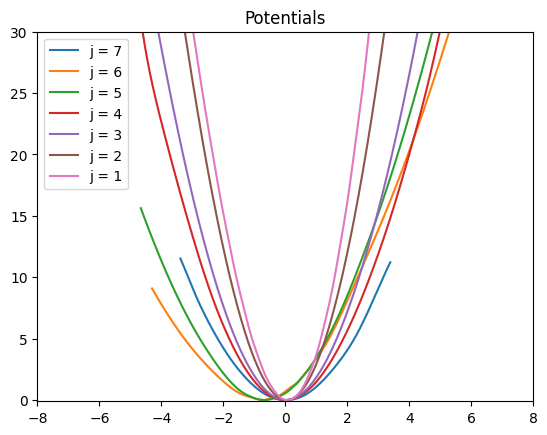

In [72]:
index_scalar=0
index_quad=1
for j in range(1,Nscale):
  Sc = ANSATZ[j-1].ansatze[index_scalar]
  window_min =Sc.centers[0]
  window_max =Sc.centers[-1]
  #POTENTIAL
  X=torch.linspace(window_min,window_max,1000).cuda()
  U=torch.sigmoid(-(X[None, :] - Sc.centers[:, None]) / (Sc.sigma[:,None] )) # (M, D) to (M,)

  #Num_potentials
  n_pot = 0
  for i in range(0,index_scalar):
    n_pot+=ansatz_union.ansatze[i].num_potentials
  n_scalar = ANSATZ[j-1].ansatze[index_scalar].num_potentials
  #theta learned
  theta =ANSATZ[j-1].theta()[n_pot:n_pot+n_scalar]

  #Compute Trace

  Sq = Square_laplacian(ANSATZ[j-1],Free=False,index_quad=index_quad)
  U=(theta@U+(Sq/2)*X**2).cpu().detach()
  U= U-(U[100:]).min()

  plt.plot(X.cpu().detach()/STD[j-1].cpu(),U.cpu(),label='j = '+str(J-j+1))
plt.legend()
plt.xlim(-8,8)
plt.ylim(-0.1,30)
plt.title('Potentials')
plt.show()